In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
# !pip install fastai==1.0.61

In [3]:
# !pip install timm

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
import os
from glob import glob
import cv2
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms
import timm

import torch.nn.functional as F


In [5]:
# %cd /kaggle/working/
# !rm -rf Endoscopy-Image-Classification
# !git clone https://github.com/taindp98/Endoscopy-Image-Classification.git
# %cd './Endoscopy-Image-Classification/code'

In [6]:
from utils import show_batch, AverageMeter, show_grid, get_config
from fixmatch import FixMatch
from comatch import CoMatch
from supervised import SupLearning
from semiformer import SemiFormer
from dataset import get_data
from build import build_model

### Supervised Learning Re-produce

In [7]:
# config = get_config('./configs/kaggle_reproduce.yaml')
# df_anno = pd.read_csv(config['DATA']['ANNO'])
# df_unanno = None
# train_dl, valid_dl = get_data(config, df_anno, df_unanno, is_visual=True, is_reprod =True)
# model = build_model(config, is_pathology = True)

### Supervised Learning Abnormalities

In [8]:
# config = get_config('./configs/kaggle_supervised_abnorm.yaml')
# df_anno = pd.read_csv(config['DATA']['ANNO'])
# df_unanno = pd.read_csv(config['DATA']['UNANNO'])
# train_dl, valid_dl = get_data(config, 
#                               df_anno, 
#                               df_unanno, 
# #                               is_full_sup = False, 
#                               is_visual=True)

# ## generate prediction abnormalities
# unlabeled_dl = get_data(config, df_anno, df_unanno, is_visual=True, predict = True)
# model = build_model(config, is_pathology = False)

### Supervised Learning Pathologies

Training mode: Full labeled supervised learning
Selected model: densenet161 w pretrained-weight
Loaded checkpoint abnormal
Build up new head MLP


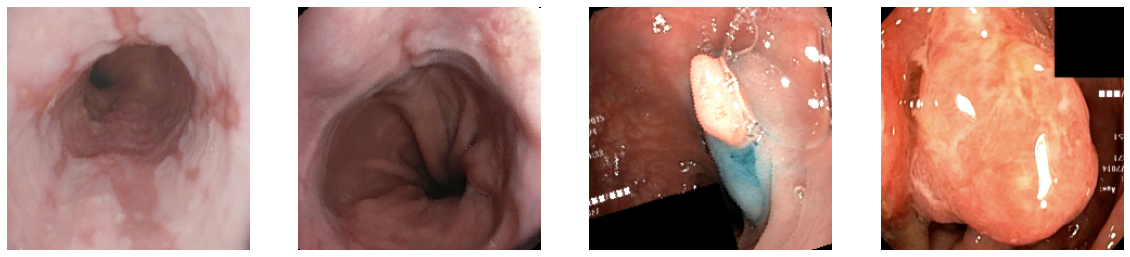

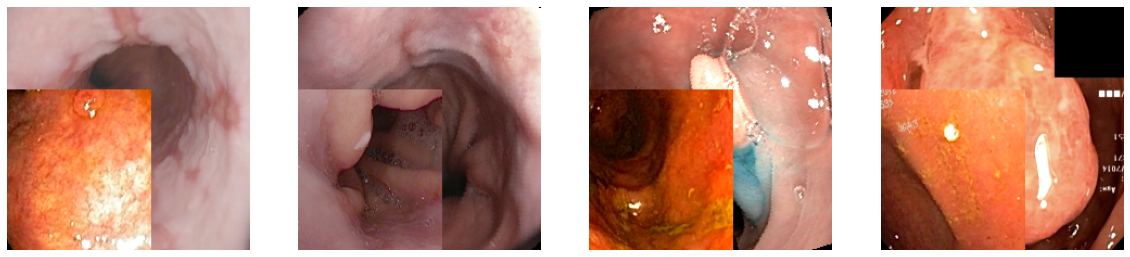

In [9]:
config = get_config('./configs/local_supervised.yaml')
df_anno = pd.read_csv(config['DATA']['ANNO'])
df_unanno = None
train_dl, valid_dl, mixup_fn = get_data(config, df_anno, df_unanno, is_visual=True)
model = build_model(config, is_pathology = True)

### Semi-supervised Learning

In [10]:
# config = get_config('./configs/kaggle_semisupervised_real_1.yaml')
# df_anno = pd.read_csv(config['DATA']['ANNO'])
# df_unanno = pd.read_csv(config['DATA']['UNANNO'])
# train_dl, valid_dl = get_data(config, 
#                               df_anno, 
#                               df_unanno, 
#                               is_full_sup = False, 
#                               is_visual=True, 
#                               type_semi = config.MODEL.TYPE_SEMI)

# model = build_model(config, is_pathology = True)

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [12]:
if config.TRAIN.IS_SSL:
    if config.MODEL.TYPE_SEMI == 'FixMatch':
        classifier = FixMatch(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
    elif config.MODEL.TYPE_SEMI == 'CoMatch':
        classifier = CoMatch(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
    elif config.MODEL.TYPE_SEMI == 'SemiFormer':
        classifier = SemiFormer(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
else:
    classifier = SupLearning(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
    
classifier.get_dataloader(train_dl, valid_dl, mixup_fn)
classifier.get_config(config)

Training mode: Supervised Learning


In [ ]:
classifier.fit()

Training epoch: 1 | Current LR: 0.000500


  2%|▊                                                 | 1/62 [01:15<1:16:42, 75.44s/it, loss=1.81]

In [ ]:
# classifier.save_checkpoint('/kaggle/working/')

In [ ]:
# classifier.load_checkpoint('D:\\model\\endoscopy\\hyper_kvasir\\sup_densenet161\\06_27_2022_16_03_56_epoch_35_6_pathos_adam.pth')

In [ ]:
# classifier.evaluate_one(True, True, True)

In [ ]:
# out_pred = classifier.inference(unlabeled_dl)

In [ ]:
# out_pred

In [ ]:
# df_unanno['pred'] = list(out_pred)
# df_unanno['pred'].value_counts()

In [ ]:
# df_unanno.to_csv("/kaggle/working/full_unlabeled_predict.csv", header =True, index = False)

In [ ]:
# classifier.fit()

In [ ]:
# classifier.save_checkpoint('/kaggle/working/')

In [ ]:
# classifier.load_checkpoint('/kaggle/working/06_29_2022_10_33_55_epoch_20.pth')

In [ ]:
# classifier.evaluate_one(True, True, True)